In [172]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [173]:
# Carga el dataset en un dataframe
df = pd.read_csv('weatherAUS.csv')

# Revisa si hay filas duplicadas
df.duplicated().sum() # 0 filas duplicadas

pd.set_option('display.max_columns', None)
df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,141232,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2017-06-24,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,10838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,NaN,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,NaN,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,NaN,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,NaN,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,NaN,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


In [183]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [145]:
print(f"El dataframe posee {len(df.columns)} variables:\n" + "\n".join(f"  - {col}" for col in df.columns))

El dataframe posee 23 variables:
  - Date
  - Location
  - MinTemp
  - MaxTemp
  - Rainfall
  - Evaporation
  - Sunshine
  - WindGustDir
  - WindGustSpeed
  - WindDir9am
  - WindDir3pm
  - WindSpeed9am
  - WindSpeed3pm
  - Humidity9am
  - Humidity3pm
  - Pressure9am
  - Pressure3pm
  - Cloud9am
  - Cloud3pm
  - Temp9am
  - Temp3pm
  - RainToday
  - RainTomorrow


# Limpieza y preprocesamiento

Análsis de faltantes:

In [146]:
faltantes_df = pd.DataFrame({
    'NaN': df.isna().sum(),
    '%': (df.isna().sum() / len(df) * 100).round(2)
}).sort_values('NaN', ascending=False)
faltantes_df

,NaN,%
Sunshine,69835,48.01
Evaporation,62790,43.17
Cloud3pm,59358,40.81
Cloud9am,55888,38.42
Pressure9am,15065,10.36
Pressure3pm,15028,10.33
WindDir9am,10566,7.26
WindGustDir,10326,7.10
WindGustSpeed,10263,7.06
Humidity3pm,4507,3.10


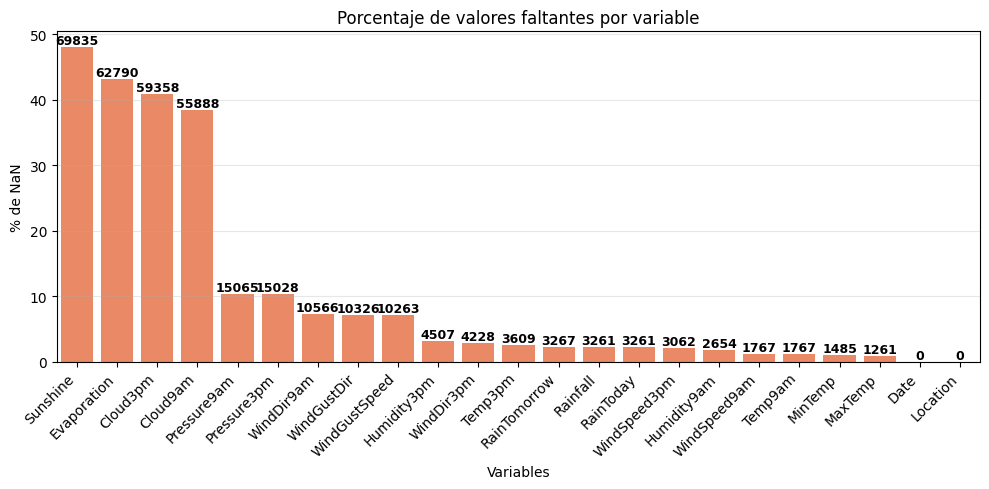

In [147]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=faltantes_df.index, y=faltantes_df['%'], color='coral')
plt.title('Porcentaje de valores faltantes por variable')
plt.xlabel('Variables')
plt.ylabel('% de NaN')
plt.xticks(rotation=45, ha='right')

for i, idx in enumerate(faltantes_df.index):
    ax.text(i, faltantes_df.loc[idx, '%'], f'{int(faltantes_df.loc[idx, "NaN"])}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Todas las variables poseen algún valor faltante con excepción de `Date` y de `Location`. Observamos que `Sunshine`, `Evaporation`, `Cloud3pm` y `Cloud9am` son las que presentan más valores faltantes: 47.69%, 42.79%, 40.15%, 37.74% respectivamente.

In [148]:
nan_por_fila = df.isna().sum(axis=1)

distribucion_nan = pd.DataFrame({
    'Cantidad_filas': nan_por_fila.value_counts().sort_index(),
    '%': (nan_por_fila.value_counts(normalize=True) * 100).sort_index().round(2)
})

distribucion_nan

,Cantidad_filas,%
0,56420,38.79
1,10909,7.50
2,18346,12.61
3,9782,6.72
4,28675,19.71
5,4141,2.85
6,10229,7.03
7,2277,1.57
8,1072,0.74
9,492,0.34


Existen 56420 observaciones sin faltantes, lo que representa un 38.8% del dataset. El resto posee al menos un dato faltante.

In [149]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Sunshine

In [190]:
# distribución de Sunshine según RainTomorrow
df.groupby('RainTomorrow')['Sunshine'].describe(percentiles=[0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

,count,mean,std,min,0.1%,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
RainTomorrow,,,,,,,,,,,,,,,,
No,57556.0,8.546358,3.380298,0.0,0.0,0.0,1.5,3.2,6.6,9.4,11.0,12.4,13.0,13.40,13.8,14.5
Yes,16821.0,4.471761,3.359329,0.0,0.0,0.0,0.0,0.1,1.4,4.3,7.1,9.2,10.2,11.98,13.2,13.9


In [150]:
df["RainTomorrow"].value_counts(normalize=True)

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64

El dataset está desbalanceado. Del 100% de observaciones

In [151]:
# Drop de filas con NaN en la feature objetivo
df = df.dropna(subset=['RainTomorrow'])

In [152]:
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0}).astype('Int8')
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0}).astype('Int8')

Análisis de las variables "Cloud"

In [153]:
df['Cloud3pm'].value_counts(dropna=False)

Cloud3pm
NaN    57094
7.0    18052
1.0    14827
8.0    12407
6.0     8869
2.0     7153
3.0     6836
5.0     6743
4.0     5254
0.0     4957
9.0        1
Name: count, dtype: int64

In [154]:
df['Cloud9am'].value_counts(dropna=False)

Cloud9am
NaN    53657
7.0    19749
1.0    15558
8.0    14389
0.0     8587
6.0     8072
2.0     6442
3.0     5854
5.0     5510
4.0     4373
9.0        2
Name: count, dtype: int64

Por el rango de valores que asumen las variables **Cloud9am** y **Cloud3pm** asumimos que dichas variables están medidas en octas, que es la unidad de medida empleada para describir la nubosidad observable en un determinado lugar. https://es.wikipedia.org/wiki/Octa

In [155]:
def generar_csv_coordenadas(df):
    import time
    import pandas as pd
    from geopy.geocoders import Nominatim

    ubicaciones = df['Location'].unique()
    australia_coords = pd.DataFrame({"location": ubicaciones})

    geolocator = Nominatim(user_agent="australia_mapper")

    lats, lons = [], []

    def normalizar_nombre_ubicacion(ubicacion):
        for i in range(1, len(ubicacion)):
            if ubicacion[i].isupper():
                return ubicacion[:i] + " " + ubicacion[i:]
        return ubicacion

    nombres_ubicaciones =  map(normalizar_nombre_ubicacion, ubicaciones)

    for ubicacion in nombres_ubicaciones:
        result = geolocator.geocode(f"{ubicacion}, Australia", timeout=10)
        if result:
            lats.append(result.latitude)
            lons.append(result.longitude)
        else:
            print('No se encontró', ubicacion)
            lats.append(None)
            lons.append(None)
        time.sleep(1.1)  # máx 1 req/s


    australia_coords["lat"] = lats
    australia_coords["lon"] = lons

    australia_coords.to_csv("australian_locations.csv", index=False)

In [156]:
# generar_csv_coordenadas(df) # Descomentar para generar el CSV

In [157]:
# Df con coordenadas
australia_coords = pd.read_csv("australian_locations.csv")

# Genera variable frecuencia para cada ubicación
australia_coords['frecuencia'] = df['Location'].value_counts().values

In [158]:
import plotly.express as px

fig = px.scatter_geo(
    australia_coords,
    lat='lat',
    lon='lon',
    scope='oceania',
    color='frecuencia',
    hover_name='location',
    projection='natural earth',
    color_continuous_scale='Purp',
)

# Ajusta los límites del mapa para centrarse en Australia
fig.update_geos(
    lonaxis=dict(range=[min(australia_coords['lon'])-5, max(australia_coords['lon'])+5]),
    lataxis=dict(range=[min(australia_coords['lat'])-5, max(australia_coords['lat'])+5]),
)
fig.update_layout(width=1600,height=900)

fig.update_traces(marker_size=20)

fig.show()

Observamos que tenemos datos de muchas ubicaciones distintas, implicando que tendremos que generar una gran cantidad de variables dummys lo que corre riesgo de overfitting. Vamos a reducir la dimensionalidad agrupando ubicaciones según sus tipos de clima, siguiendo la clasificación de Koppen. 

In [159]:
# Genera una nueva variable Climate basada en la clásificación de Koppen, utilizando la variable Location

location_koppen = {
    'Adelaide': 'Temperate',
    'Albany': 'Temperate',
    'Albury': 'Temperate',
    'AliceSprings': 'Arid',
    'BadgerysCreek': 'Temperate',
    'Ballarat': 'Temperate',
    'Bendigo': 'Temperate',
    'Brisbane': 'Temperate',
    'Cairns': 'Tropical',
    'Canberra': 'Temperate',
    'Cobar': 'Arid',
    'CoffsHarbour': 'Temperate',
    'Dartmoor': 'Temperate',
    'Darwin': 'Tropical',
    'GoldCoast': 'Temperate',
    'Hobart': 'Temperate',
    'Katherine': 'Tropical',
    'Launceston': 'Temperate',
    'Melbourne': 'Temperate',
    'Mildura': 'Arid',
    'Moree': 'Temperate',
    'MountGambier': 'Temperate',
    'MountGinini': 'Temperate',
    'Newcastle': 'Temperate',
    'Nhil': 'Temperate',
    'NorahHead': 'Temperate',
    'NorfolkIsland': 'Temperate',
    'Nuriootpa': 'Temperate',
    'PearceRAAF': 'Temperate',
    'Penrith': 'Temperate',
    'Perth': 'Temperate',
    'PerthAirport': 'Temperate',
    'Portland': 'Temperate',
    'Richmond': 'Temperate',
    'Sale': 'Temperate',
    'SalmonGums': 'Arid',
    'Sydney': 'Temperate',
    'SydneyAirport': 'Temperate',
    'Townsville': 'Tropical',
    'Tuggeranong': 'Temperate',
    'Uluru': 'Arid',
    'WaggaWagga': 'Temperate',
    'Walpole': 'Temperate',
    'Watsonia': 'Temperate',
    'Williamtown': 'Temperate',
    'Witchcliffe': 'Temperate',
    'Wollongong': 'Temperate',
    'Woomera': 'Arid',
}

In [160]:
# Genera la nueva variable en el df original y en el df de coordenadas
df['Climate'] = df['Location'].map(location_koppen)

australia_coords['Climate'] = australia_coords['location'].map(location_koppen)

In [161]:
import plotly.express as px

fig = px.scatter_geo(
    australia_coords,
    lat='lat',
    lon='lon',
    scope='oceania',
    color='Climate',
    hover_name='location',
    projection='natural earth',
    size='frecuencia',
)

# Ajusta los límites del mapa para centrarse en Australia
fig.update_geos(
    lonaxis=dict(range=[min(australia_coords['lon'])-5, max(australia_coords['lon'])+5]),
    lataxis=dict(range=[min(australia_coords['lat'])-5, max(australia_coords['lat'])+5]),
)
fig.update_layout(width=1600,height=900)

fig.show()

### Split Train/Test

In [162]:
# Separa el 80% para train y 20% para test
train, test= train_test_split(df, test_size=0.2, random_state=1)

# EDA

In [163]:
variables_numericas = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Hay {len(variables_numericas)} variables_numericas:\n{variables_numericas}")

Hay 16 variables_numericas:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


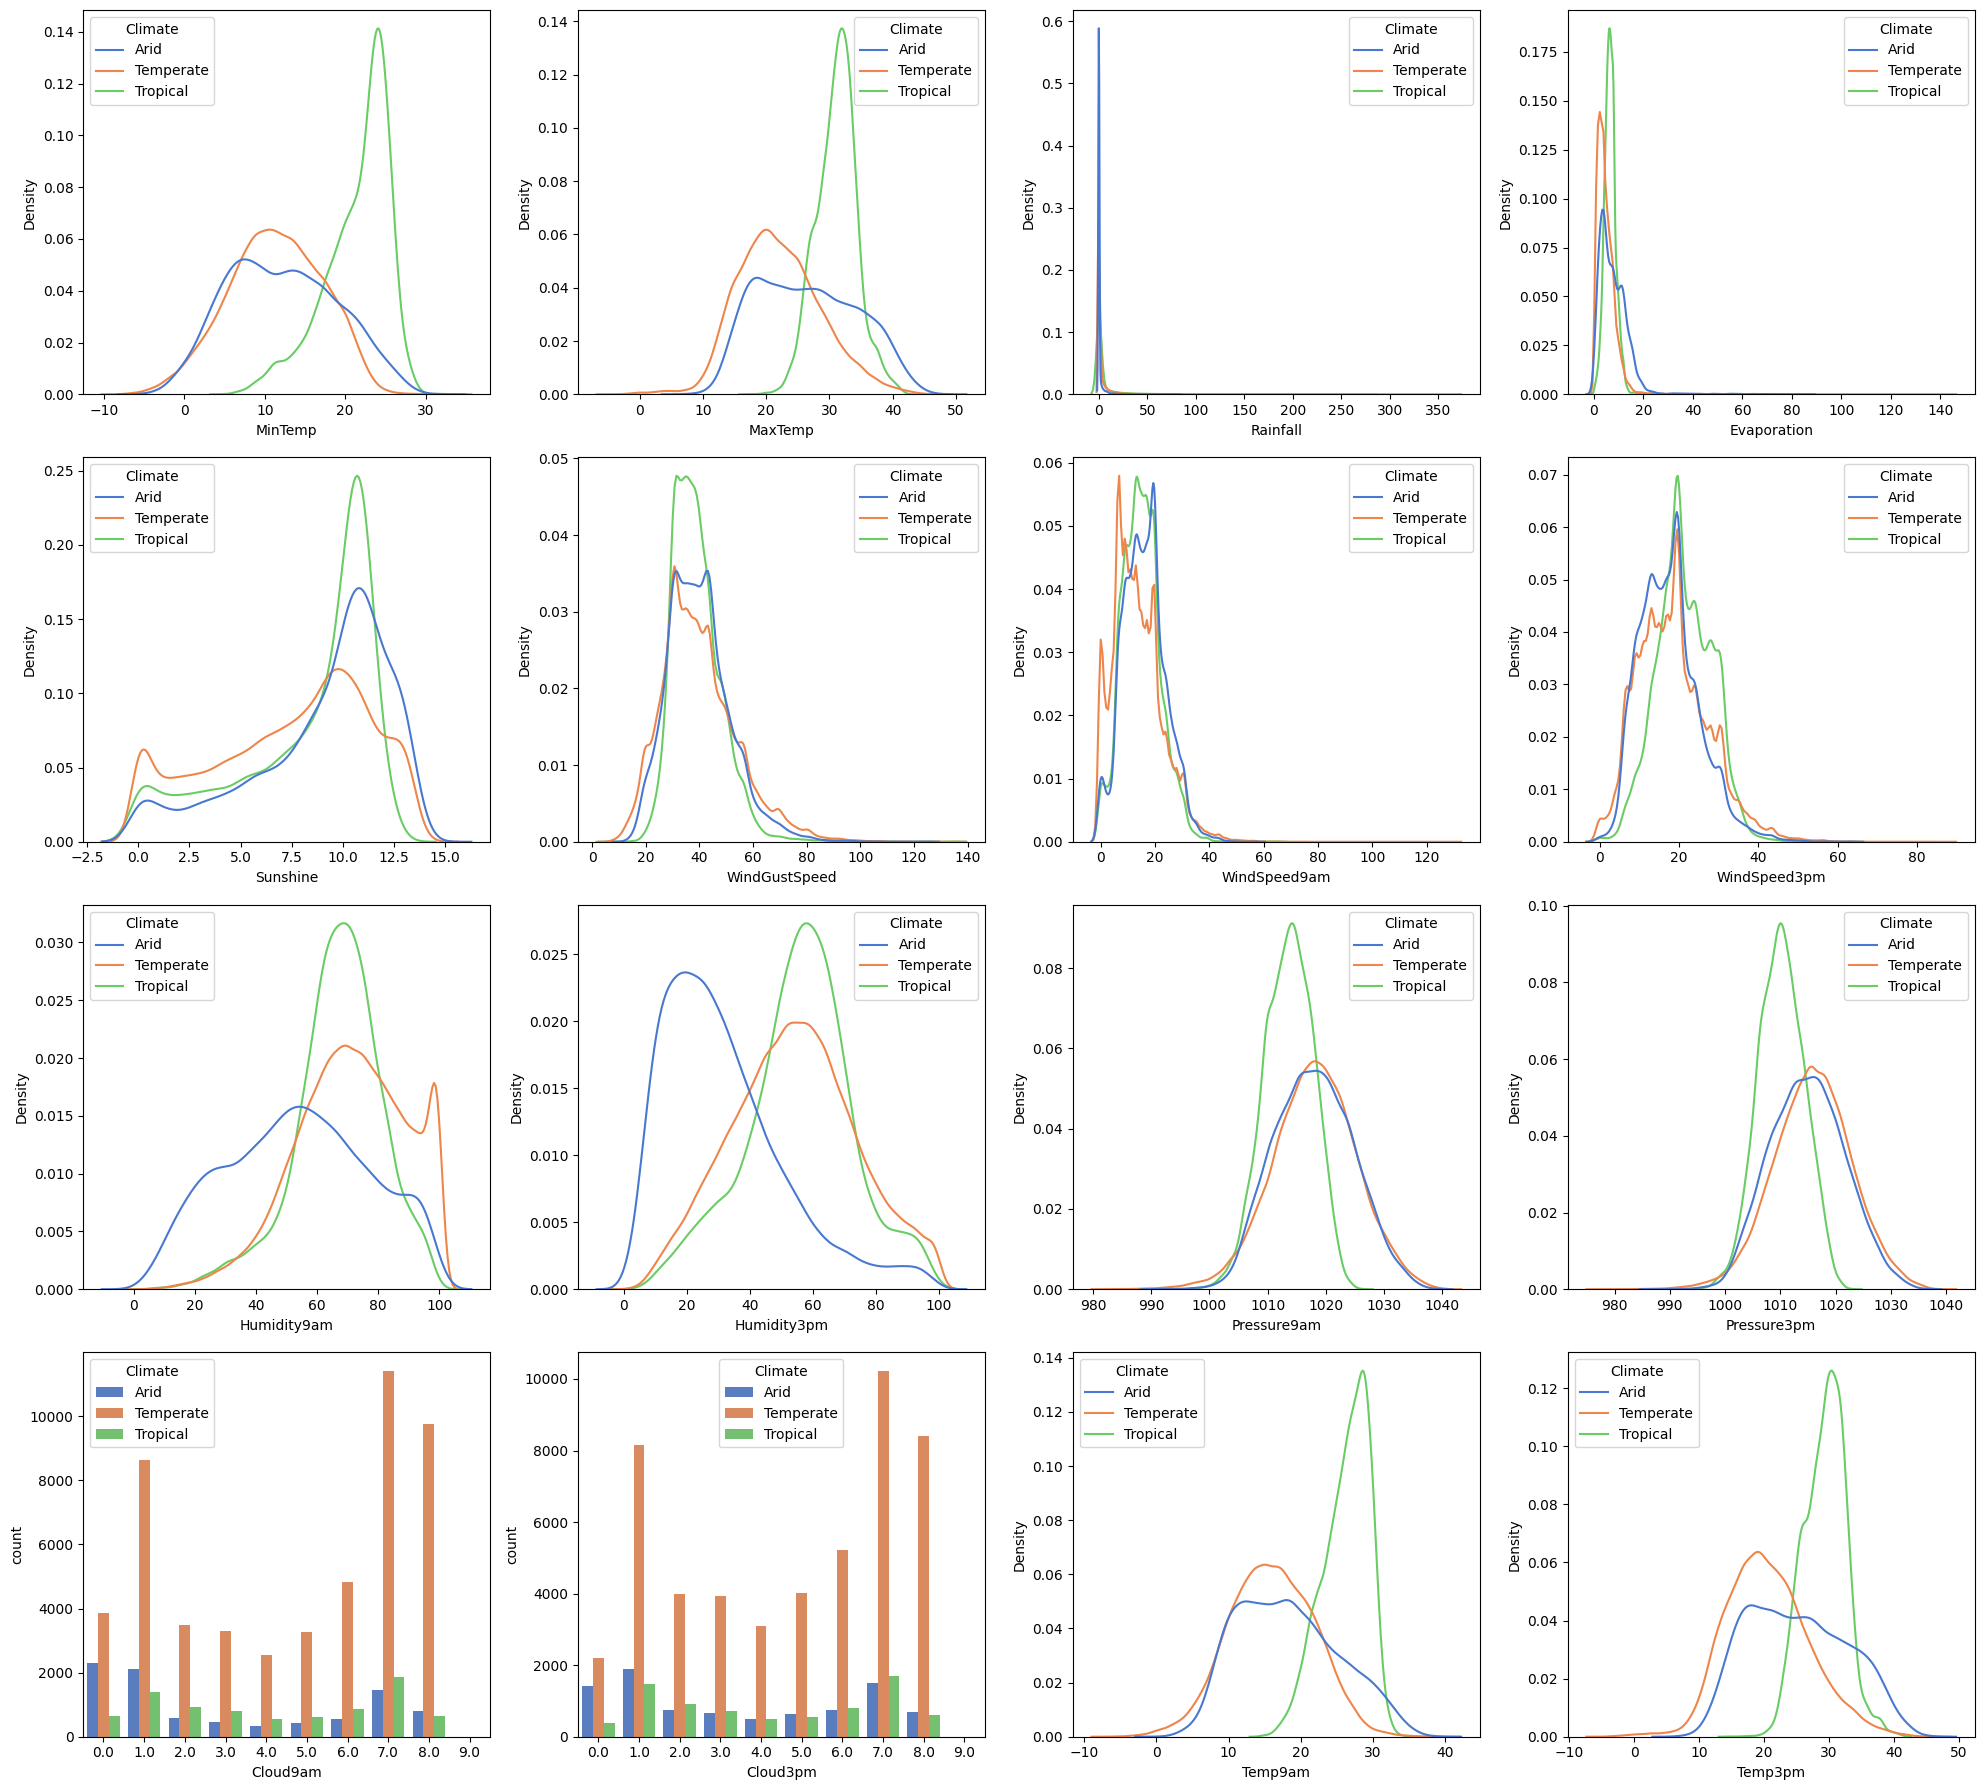

In [164]:
# Distribución de variables
fig, axes = plt.subplots(4, 4, figsize=(20, 18))

for i, var in enumerate(variables_numericas):
    if var == 'Cloud3pm' or var == 'Cloud9am':
        sns.countplot(data=train, x=var, hue='Climate', palette='muted', ax=axes[i // 4, i % 4], hue_order=['Arid', 'Temperate', 'Tropical'])
    else:
        sns.kdeplot(data=train, x=var, hue='Climate', palette='muted', ax=axes[i // 4, i % 4], hue_order=['Arid', 'Temperate', 'Tropical'], common_norm=False)

plt.tight_layout()
plt.show()

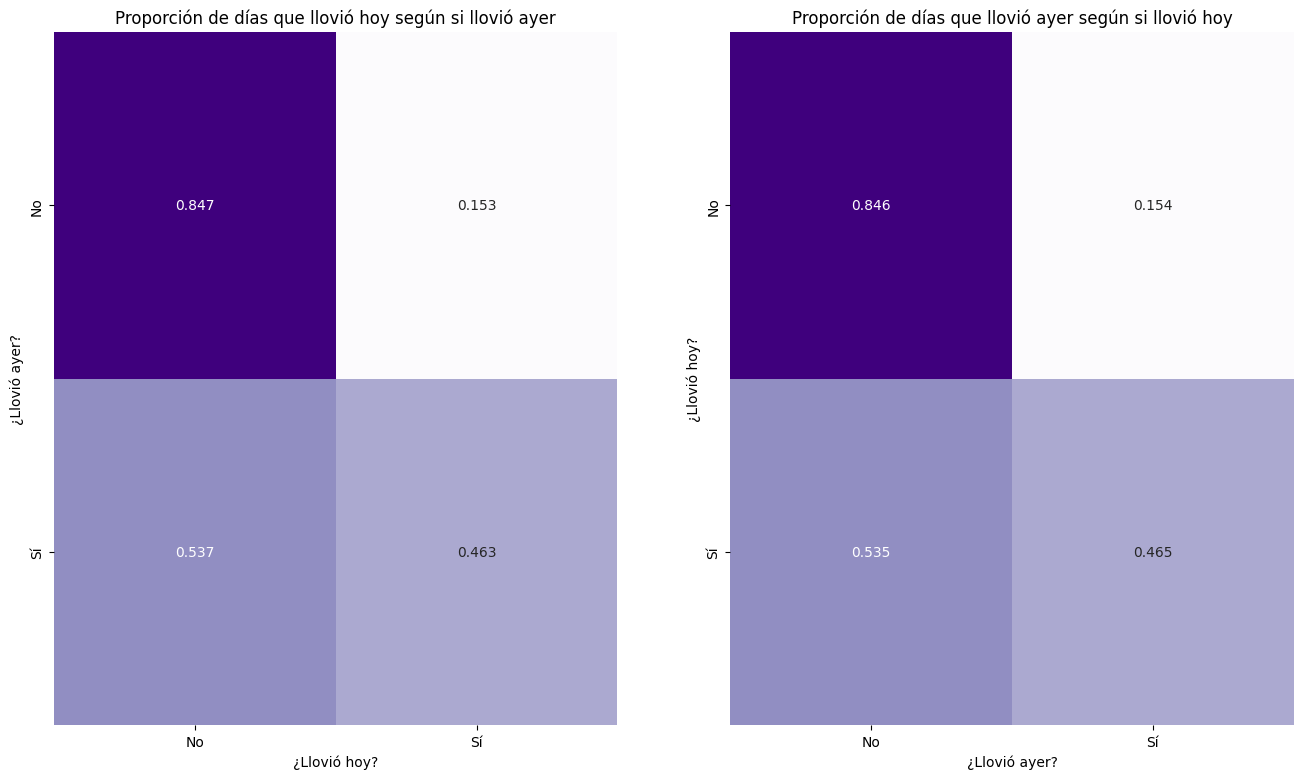

In [165]:
ayer_segun_hoy = pd.crosstab(train['RainTomorrow'], train['RainToday'], normalize='index')
hoy_segun_ayer = pd.crosstab(train['RainToday'], train['RainTomorrow'], normalize='index')


fig, axes = plt.subplots(1, 2, figsize=(16, 9))

sns.heatmap(hoy_segun_ayer, annot=True, cmap='Purples', fmt='.3f', cbar=False, ax=axes[0])
sns.heatmap(ayer_segun_hoy, annot=True, cmap='Purples', fmt='.3f', cbar=False, ax=axes[1])

axes[0].set_title('Proporción de días que llovió hoy según si llovió ayer')
axes[0].set_xticks(ticks=[0.5, 1.5], labels=['No', 'Sí'])
axes[0].set_yticks(ticks=[0.5, 1.5], labels=['No', 'Sí'])
axes[0].set_xlabel('¿Llovió hoy?')
axes[0].set_ylabel('¿Llovió ayer?')

axes[1].set_title('Proporción de días que llovió ayer según si llovió hoy')
axes[1].set_xticks(ticks=[0.5, 1.5], labels=['No', 'Sí'])
axes[1].set_yticks(ticks=[0.5, 1.5], labels=['No', 'Sí'])
axes[1].set_xlabel('¿Llovió ayer?')
axes[1].set_ylabel('¿Llovió hoy?')

plt.show()

In [166]:
train['Rainfall'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, .999, .9999])

count     112634.000000
mean           2.342761
std            8.384097
min            0.000000
25%            0.000000
50%            0.000000
75%            0.800000
90%            6.000000
95%           13.000000
99%           37.600000
99.9%        100.913800
99.99%       187.841480
max          371.000000
Name: Rainfall, dtype: float64

In [167]:
train = train[train['Rainfall'] < 188]
test = test[test['Rainfall'] < 188]

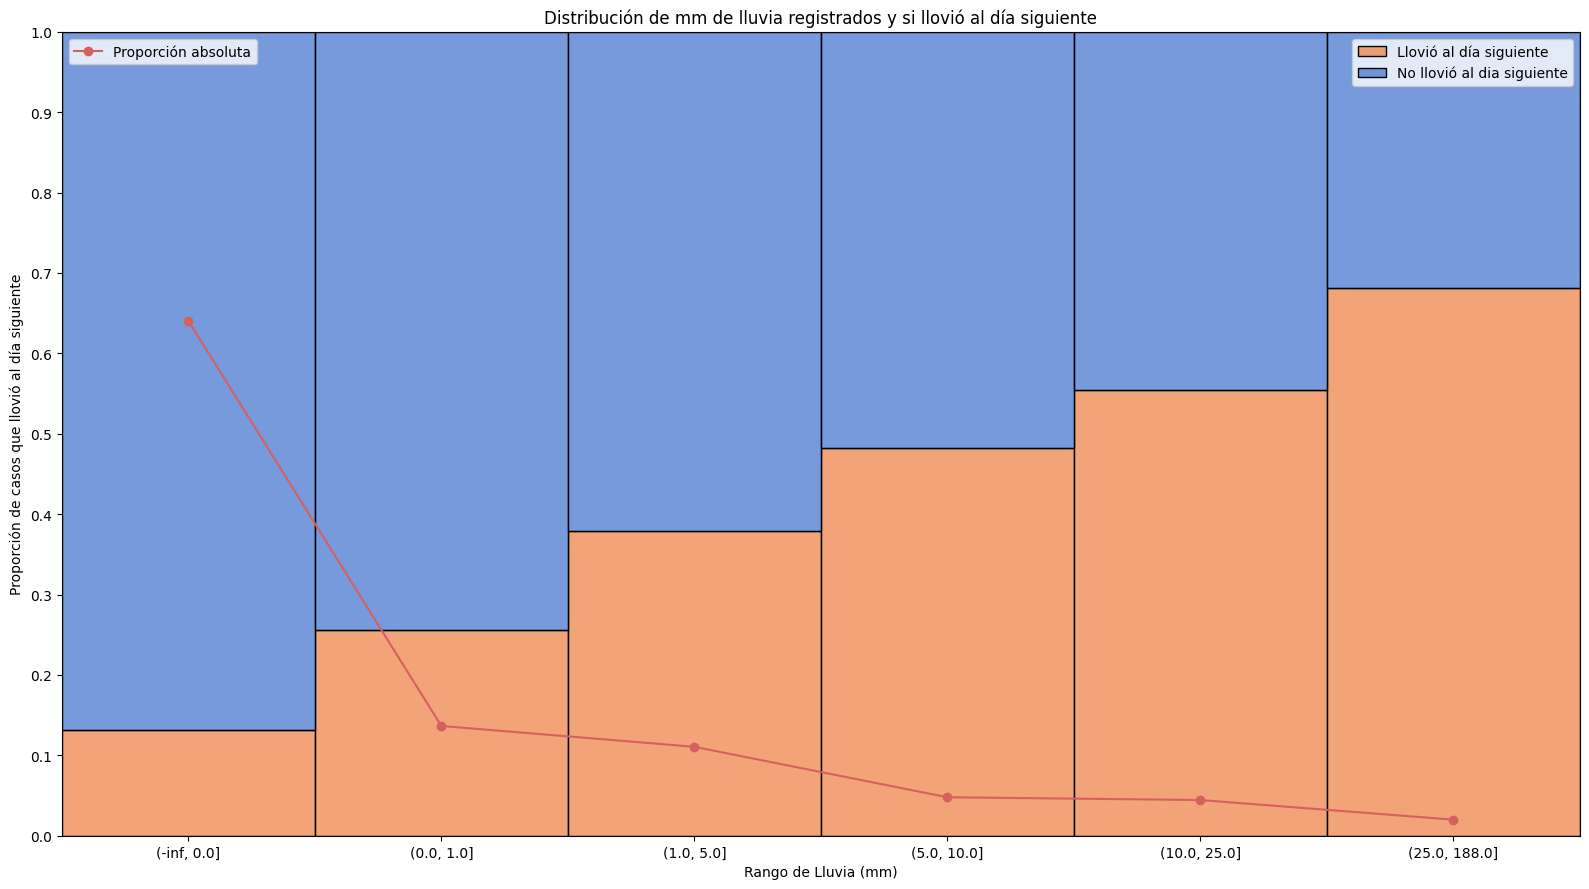

In [168]:
# Crea los bins para Rainfall
bins = [float('-inf'), 0, 1, 5, 10, 25, 188]

intervalos = pd.cut(train['Rainfall'], bins=bins, right=True)

train['Rainfall_range'] = intervalos
# Convierte los intervalos a strings para que Seaborn pueda manejarlos
train['Rainfall_range'] = train['Rainfall_range'].astype(str)

# Asegura que los rangos mantengan el orden
train['Rainfall_range'] = pd.Categorical(
    train['Rainfall_range'],
    categories=[str(interval) for interval in intervalos.cat.categories],
    ordered=True
)

frecuencias = train['Rainfall_range'].value_counts(normalize=True).sort_index()

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.histplot(
    data=train,
    x='Rainfall_range',
    hue='RainTomorrow',
    palette='muted',
    multiple='fill',  # Mostrar proporciones dentro de cada bin
    ax=ax1,
)

ax1.set_xlabel('Rango de Lluvia (mm)')
ax1.set_ylabel('Proporción de casos que llovió al día siguiente')
ax1.set_title('Distribución de mm de lluvia registrados y si llovió al día siguiente')

ax1.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

ax1.legend(title='', labels=['Llovió al día siguiente', 'No llovió al dia siguiente'], loc='upper right')

# Segundo eje para la proporción absoluta
ax2 = ax1.twinx()
ax2.plot(frecuencias.index, frecuencias, color=sns.color_palette('muted')[3], marker='o', label='Proporción absoluta')
ax2.legend(loc='upper left')

# Oculta el eje y secundario; tiene la misma escala que el principal.
ax2.set_axis_off()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### Variable **Evaporation**

In [169]:
train['Evaporation'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, .999, .9999])

count     64915.000000
mean          5.463811
std           4.177057
min           0.000000
25%           2.600000
50%           4.800000
75%           7.400000
90%          10.200000
95%          12.000000
99%          18.400000
99.9%        40.834400
99.99%       70.203440
max         145.000000
Name: Evaporation, dtype: float64

In [170]:
train = train[train['Evaporation'] < 71]
test = test[test['Evaporation'] < 71]